### SMA Volatility & Correlation

In [39]:
price = csvread('price.csv');

In [41]:
x = price2ret(price);

In [42]:
SMA_vol = std(x)

SMA_corr = corr(x)


SMA_vol =

    0.0139    0.0173    0.0193


SMA_corr =

    1.0000    0.8055    0.5173
    0.8055    1.0000    0.3569
    0.5173    0.3569    1.0000



### EWMA Volatility & Correlation

In [ ]:
function vol = EWMA_Vol(price, lambda)
    x     = price2ret(price);
    [m,n] = size(x);
    vol = zeros(1, n);
    
    for j=1:n
        k      = (1:m)';
        h      = (m:-1:1)';
        vol(j) = sqrt((1-lambda)*sum(lambda.^(k-1).*x(h,j).^2));
    end
        

In [45]:
price = csvread('price.csv');

In [46]:
EWMA_Vol(price, 0.94)


ans =

    0.0167    0.0171    0.0240



In [ ]:
function [vol, rho] = EWMA_VolCorr(price, lambda)
    x      = price2ret(price);
    [m, n] = size(x);
    
    k = (1:m)';
    h = (m:-1:1)';
    
    cvar = zeros(n);
    for i=1:n
        for j=1:n
            cvar(i, j) = (1-lambda) * sum(lambda.^(k-1) .* x(h, i) .* x(h, j));
        end
    end
    
    rho = zeros(n);
    for i=1:n
        for j=1:n
            rho(i, j) = cvar(i, j) / sqrt(cvar(i,i) * cvar(j, j));
        end
    end
   
    vol = sqrt(diag(cvar))';
    
    

In [50]:
[vol, rho] = EWMA_VolCorr(price, 0.94)


vol =

    0.0167    0.0171    0.0240


rho =

    1.0000    0.8930    0.6554
    0.8930    1.0000    0.6135
    0.6554    0.6135    1.0000



### 최우추정법(Maximum Likelihood Method)
- 주어진 데이터의 발생 가능성(likelihood)을 가장 크게 하는 모수 값을 찾아내는 것
- 데이터의 확률분포를 알 때, 어떠한 모수를 추정해야 실제 관찰된 데이터의 발생확률이 제일 큰가의 문제

In [ ]:
function f=SMA_llh(b, x)
    f = sum(log(b)+(x.^2)/b);

In [ ]:
function f=EWMA_llh(b, x)
    V = zeros(length(x)-1, 1);
    V(1) = x(1)^2;
    
    for i=2:length(x)-1
        V(i) = (1-b) * x(i)^2 + b*V(i-1)
    end
    
    f = sum(log(V)+ (x(2:end).^2)./V);

### GARCH(Generalized Autoregressive Conditional HeteroScedasticity)
- GARCH는 조건부 분산(Conditional Variance)이 자기회귀과정(Autoregressive Process)을 따른다는 의미로서 변동성이 특정 패턴을 가지고 시간에 따라 변한다는 것
- GARCH모형은 EWMA모형에서 확장된 형태로 추정 변동성이 최근일의 수익률과 분산 뿐만 아니라 장기 평균 분산에 의해서도 결정된다는 것
- 일반적으로 모수들은 최우추정방법(Maximum Likelihood Methods)을 이용하여 추정

In [ ]:
function f=GARCH_llh(b, x)
    VL   = var(x);
    V    = zeros(length(x)-1, 1);
    V(1) = x(1)^2;
    
    for i=2:length(x)-1
        V(i) = (1-b(1)-b(2)) * VL + b(1) * x(i)^2 + b(2)*V(i-1);
    end
    
    f = sum(log(V) + (x(2:end).^2)./V);
    

In [1]:
x=csvread('KOSPI200.csv');
x = price2ret(x);
o = optimset('maxiter', 300);

In [4]:
SMA_b0 = 0.01;
[SMA_var, SMA_fval]    = fminsearch(@SMA_llh, SMA_b0, o, x)

EWMA_b0 = 0.9;
[EWMA_para, EWMA_fval] = fminsearch(@EWMA_llh, EWMA_b0, o, x)

GARCH_b0 = [0.1, 0.8];
[GRACH_para, GARCH_fval] = fminsearch(@GARCH_llh, GARCH_b0, o, x)


SMA_var =

   2.1167e-04


SMA_fval =

  -9.3183e+03


EWMA_para =

    0.9371


EWMA_fval =

  -9.4924e+03


GRACH_para =

    0.0737    0.9101


GARCH_fval =

  -9.5117e+03



### 내재변동성

In [ ]:
%Bisection Method

function Imp_Vol = Bisection_ImpVol(C_P, S, X, r, T, q, MP)
    V_low  = 0.01;
    V_high = 2;
    tol    = 0.000001;
    
    P_low  = BS_Vanilla(C_P, S, X, r, T, V_low, q);
    P_high = BS_Vanilla(C_P, S, X, r, T, V_high, q);
    
    vi = V_low + (MP-P_low)*(V_high-V_low)/(P_high-P_low);
    
    while abs(MP-BS_Vanilla(C_P, S, X, r, T, vi, q)) > tol
        if BS_Vanilla(C_P, S, X, r, T, vi, q) < MP
            V_low = vi;
        else
            V_high = vi;
        end
        
        P_low  = BS_Vanilla(C_P, S, X, r, T, V_low, q);
        P_high = BS_Vanilla(C_P, S, X, r, T, V_high, q);
        
        vi = V_low + (MP-P_low)*(V_high-V_low)/(P_high-P_low);
    end
    
    Imp_Vol = vi;
    
    

In [6]:
Bisection_ImpVol('C', 100, 100, 0.05, 0.5, 0, 10)


ans =

    0.3133



In [ ]:
function Imp_Vol = Newton_ImpVol(C_P, S, X, r, T, q, MP)
    vol = 0.2;
    tol = 0.000001;
    
    P    = BS_Vanilla(C_P, S, X, r, T, vol, q);
    vega = BS_Vanilla_Greeks(C_P, 'vega', S, X, r, T, vol, q);
    
    while abs(P- MP)> tol
        vol  = vol - (P-MP) / vega;
        P    = BS_Vanilla(C_P, S, X, r, T, vol, q);
        vega = BS_Vanilla_Greeks(C_P, 'vega', S, X, r, T, vol, q);
    end
    
    Imp_Vol = vol;

In [7]:
Newton_ImpVol('C', 100, 100, 0.05, 0.5, 0, 10)


ans =

    0.3133



In [9]:
blsimpv(100, 100, 0.05, 0.5, 10)


ans =

    0.3133



### 변동성 기간구조 (Volatility Term Structure) 추정

- 옵션에 내재된 변동성이 행사가격에 따라 스마일(smile) 또는 스큐(skew)된 곡선 형태를 보여주는 현상을 변동성 스마일(Volatility Smile)이라 하며, 잔존만기에 따라 다르게 나타나는 것을 변동성 기간구조라 함
- 변동성 표면(Volatility Surface)은 변동성 스마일과 변동성 기간구조를 결합한 것으로서 행사가격과 잔존만기별 변동성을 3차원 형태로 나타낸 것으로 임의의 행사가격과 만기를 갖는 옵션의 가격을 구하는데 이용 가능
  - 즉, 시장에서 거래가 없거나 신규 개발된 옵션의 변동성 적용에 활용할 수 있으며 유한차분법의 격자에 접목시킬 경우 상수 변동성 가정인 BS모델의 대안이 됨
- 변동성 기간 구조는 GARCH(1,1)를 이용하여 추정할 것 

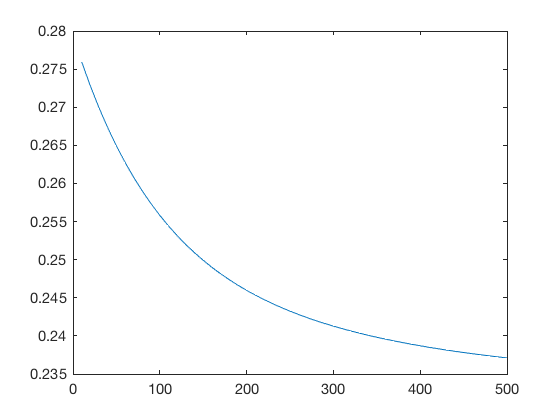

In [18]:
%GARCH(1,1) Volatility Term Structure

alpha=0.0737; beta=0.9101; VL=0.000211; Vt=0.000309;

N=10:10:500;
vol_term = zeros(length(N), 1);

for i=1:length(N)
    k=1:N(i)-1;
    V_term      = [Vt VL + ((alpha+beta).^k)*(Vt-VL)];
    vol_term(i) = sqrt(mean(V_term))*sqrt(252);
end
    
term_structure = [N; vol_term'];
plot(N, vol_term)

### 국소변동성표면(Local Volatility Surface)

- 모든 행사가격 X와 만기 T에 대하여 옵션의 가격이 주어진다면 이들 가격들로부터 BS편미분 방정식을 통해 X와 T의 함수인 변동성 $\sigma_L(X,T)$를 구할 수 있음
  - Dupire(1994)는 기초자산가격이 Risk-Neutral Random Walk를 따르고 모든 행사가격X와 만기 T에 대해 유럽형 바닐라옵션의 무차익시장가격이 존재한다면 이들로부터 국소변동성을 분석적으로 도출 가능함을 보임
  - 내재변동성과 다른 점은 국소변동성은 시장가격과 BS편미분방정식에 내재된 변동성이라는 점
- 하지만, Dupire 국소변동성표면은 두 가지 문제점을 안고 있음
  - 올바른 국소변동성 표면을 구하기 위한 행사가격별 및 만기별 옵션 시장 가격들이 충분히 제공되지 않음
  - 행사가격과 멀리 떨어진 심외가격옵션과 심내가격 옵션의 경우 식의 분자와 분모항의 값이 너무 작아져서 수치적으로 부정확한 값 산출
- 이를 보완하는 방법 중 Elder(2002)는 내재변동성 함수 $\sigma_I(X,T)$을 이용하여 국소변동성 표면식을 대체할 수 있음을 보임
  - 시장 가격을 이용하여 행사가격 및 잔존만기별 내재변동성을 추정한 후 내재변동성 모형을 설정하고 최소자승법에 의해 계수 추정, 이를 다시 변형된 국소변동성 모형에 대입

In [ ]:
%Implied Volatility Function

function f=ImpVol_f(a, Mdata)
    f = a(1)+a(3)*exp(a(2)*Mdata(:,2))+a(4)*Mdata(:,1)+a(5)*Mdata(:,1).^2+a(6)*Mdata(:,1).^3+a(7)*Mdata(:,1).^4


Local minimum possible.

lsqcurvefit stopped because the final change in the sum of squares relative to 
its initial value is less than the default value of the function tolerance.





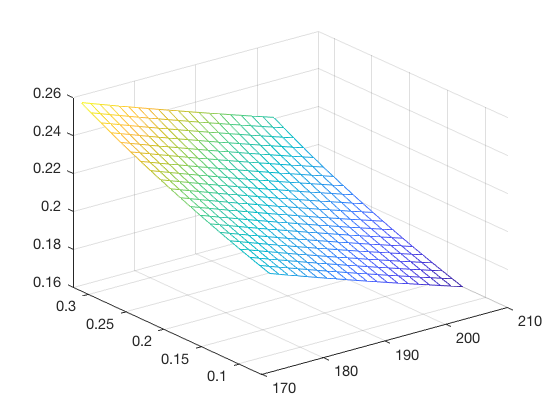

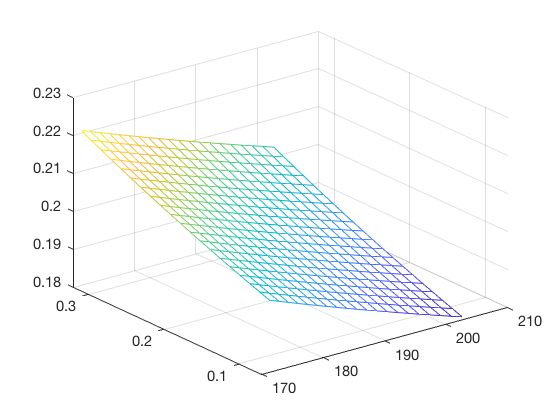

In [30]:
%Local Volatility Surface

C_P = 'C'; S=186.24; r=0.048; q=0.0029;

market_data = csvread('market_data.csv');
temp_size   = size(market_data);
X           = market_data(:, 1);
T           = market_data(:, 2);
P           = market_data(:, 3);

%1단계 : 행사가격/잔존만기별 내재변동성 추정(뉴턴랩슨)
Imp_Vol = zeros(temp_size(1), 1);
for i=1:temp_size(1)
    Imp_Vol(i) = Newton_ImpVol(C_P, S, X(i), r, T(i), q, P(i));
end

%2,3 단계 : 내재변동성 함수 모델 설정 및 계수 추정
M = log((S*exp((r-q)*T))./X);
Mdata = [M T];

a = lsqcurvefit(@ImpVol_f, [0.1 0.1 0.1 0.1 0.1 0.1 0.1], Mdata, Imp_Vol);
M = linspace(min(M), max(M), 20);
T = linspace(min(T), max(T), 20);

X = (S*exp((r-q)*T))./exp(M);

%4단계 : 내재변동성 함수 이용하여 도함수 계산
Imp_Vol = zeros(length(M), length(T));
dT      = zeros(length(M), length(T));
dX      = zeros(length(M), length(T));
dXX     = zeros(length(M), length(T));
d       = zeros(length(M), length(T));

for i=1:length(M)
    for j=1:length(T)
        Imp_Vol(i, j) = ImpVol_f(a, [M(i) T(j)]);
        dT(i, j)  = a(3)*a(2)*exp(a(2)*T(j)) + (r-q)*(a(4) +2*a(5)*M(i) +3*a(6)*M(i)^2+4*a(7)*M(i)^3);
        dX(i, j)  = -(a(4)+2*a(5)*M(i)+3*a(6)*M(i)^2+4*a(7)*M(i)^3)/X(i);
        dXX(i, j) = (a(4)+2*a(5)*(M(i)+1)+3*a(6)*M(i)*(M(i)+2)+4*a(7)*M(i)^2*(M(i)+3))/X(i)^2;
        d(i, j)   = (log(S/X(i))+(r-q+0.5*Imp_Vol(i,j)^2)*T(j))/(Imp_Vol(i,j)*sqrt(T(j)));
    end
end

%5단계 : Local Volatility Surface 계산
Local_Vol = zeros(length(X), length(T));
for i=1:length(X)
    for j=1:length(T)
        Local_Vol(i, j) = (Imp_Vol(i, j)^2+2*Imp_Vol(i, j) * T(j) *...
                          (dT(i, j) + (r-q)*X(i)*dX(i, j)))/((1+X(i)*d(i, j)*dX(i, j)*...
                          sqrt(T(j)))^2 + Imp_Vol(i, j)*X(i)^2*T(j)*(dXX(i, j)-d(i, j)*...
                          dX(i, j)^2*sqrt(T(j))));
    end
end

Local_Vol = sqrt(Local_Vol);

[X, T] = meshgrid(X, T);
Imp_Vol = Imp_Vol';
Local_Vol = Local_Vol';

figure(1)
mesh(X, T, Imp_Vol)
figure(2)
mesh(X, T, Local_Vol)